## Cre vs IkbSR-Cre 
12/14/52 - Data generated from KP Rosa26-RIK/+ mice infected with doxycycline inducible IkbSR-Cre construct vs a Cre construct control; Doxycycline was induced for 1 week at 16 weeks post tumor induction (PTI) and tumors were harvested at 17 weeks PTI. data submitted by Jason/Carleigh/CHP/Emma/Eliud/Hannah on 6/22/23

Analyze global run on cellranger v6 data and create h5_ad files for further analysis

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import math
import matplotlib
from matplotlib import pyplot as plt

from pathlib import Path
import anndata

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
np.random.seed(1573)   #fix so we can reproduce later

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"

In [4]:
Path("./figures").mkdir(parents=True, exist_ok=True) # generate figures here
Path("./write").mkdir(parents=True, exist_ok=True) # write h5ad here

In [5]:
results_file = 'write/JC2499_CrevsIkbSRCre.h5ad'  # the file that will store the analysis results

In [6]:
adata = sc.read_10x_h5('JC2499_filtered_feature_bc_matrix.h5', gex_only=False)

reading JC2499_filtered_feature_bc_matrix.h5
 (0:00:01)


/home/chanj2/part2a/lib/python3.11/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [8]:
samples = list(adata[:,adata.var['feature_types']=='Antibody Capture'].var.index)

In [9]:
print(samples)

['AY1264_B0301', 'AY1267_B0302', 'AY1268_B0303', 'AY1422_B0304', 'AY1271_B0305', 'AY1262_B0306', 'AY1263_B0307', 'AY1425_B0308', 'AY1483_B0309', 'AY1484_B0310']


In [10]:
# Now filter out barcodes
hashadata = adata[:,samples]
adata = adata[:,[y for y in adata.var_names if y not in samples]]

In [11]:
hashadata.var

gene_ids     feature_types genome  \
AY1264_B0301  AY1264_B0301  Antibody Capture          
AY1267_B0302  AY1267_B0302  Antibody Capture          
AY1268_B0303  AY1268_B0303  Antibody Capture          
AY1422_B0304  AY1422_B0304  Antibody Capture          
AY1271_B0305  AY1271_B0305  Antibody Capture          
AY1262_B0306  AY1262_B0306  Antibody Capture          
AY1263_B0307  AY1263_B0307  Antibody Capture          
AY1425_B0308  AY1425_B0308  Antibody Capture          
AY1483_B0309  AY1483_B0309  Antibody Capture          
AY1484_B0310  AY1484_B0310  Antibody Capture          

                                pattern read         sequence  
AY1264_B0301  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  ACCCACCAGTAAGAC  
AY1267_B0302  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  GGTCGAGAGCATTCA  
AY1268_B0303  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  CTTGCCGCATGTCAT  
AY1422_B0304  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  AAAGCATTCTTCACG  
AY1271_B0305  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  CTTTGTCTTTGTGAG  
AY1262_B0306  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  TATGCTGCCACGGTA  
AY1263_B0307  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  GAGTCTGCCAGTATC  
AY1425_B0308  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  TATAGAACGCCAGGC  
AY1483_B0309  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  TGCCTATGAAACAAG  
AY1484_B0310  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  CCGATTGTAACAGAC

## Preprocessing

/home/chanj2/part2a/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


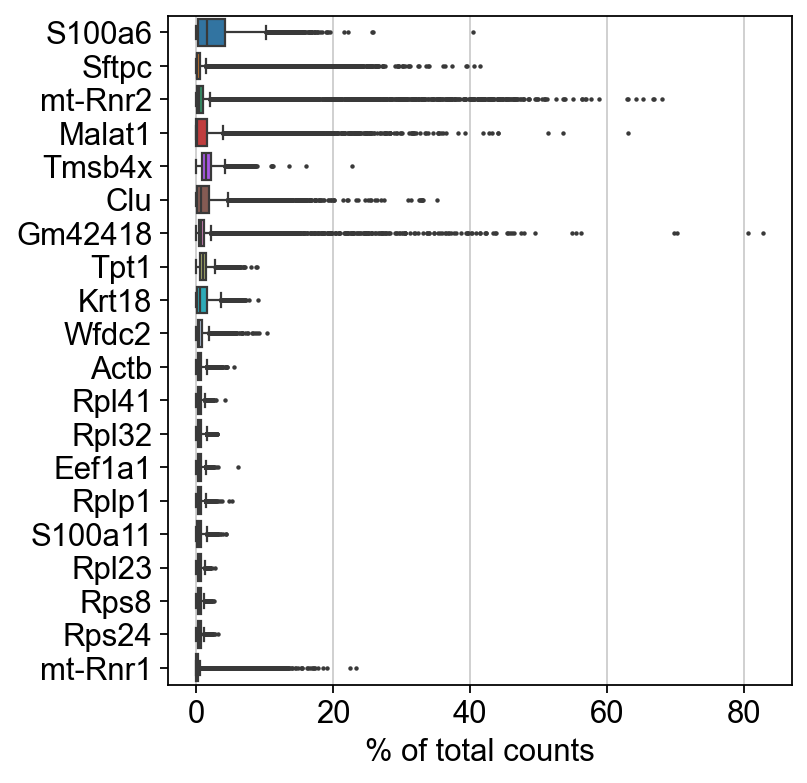

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering:

In [13]:
sc.pp.filter_cells(adata, min_counts=1500)
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1023 cells that have less than 1500 counts
filtered out 18 cells that have less than 300 genes expressed
filtered out 29416 genes that are detected in less than 3 cells


In [14]:
adata.var['mt'] = adata.var_names.str.startswith('mt-') # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [15]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, rotation=90)

In [16]:
adata.obs["log10GenesPerUMI"] = adata.obs['n_genes_by_counts'].apply(math.log10) / adata.obs['total_counts'].apply(math.log10)
matplotlib.pyplot.hist(adata.obs["log10GenesPerUMI"])

(array([   6.,   58.,  385., 1494., 2706., 4330., 4720., 2898.,  760.,
          28.]),
 array([0.67302963, 0.70115142, 0.72927322, 0.75739502, 0.78551681,
        0.81363861, 0.84176041, 0.8698822 , 0.898004  , 0.9261258 ,
        0.95424759]),
 <BarContainer object of 10 artists>)

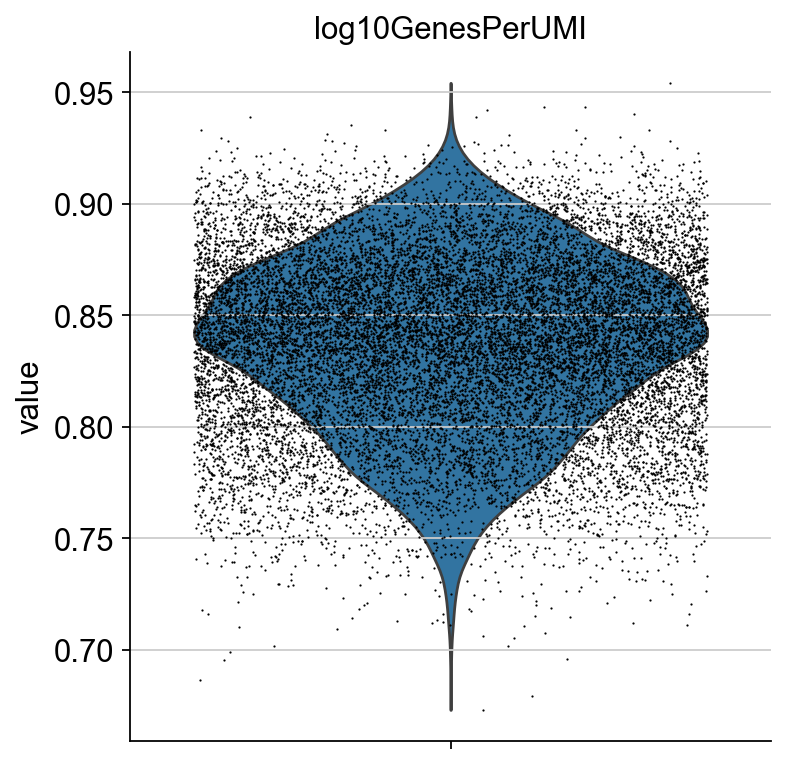

In [17]:
sc.pl.violin(adata, ['log10GenesPerUMI'],
             jitter=0.4, multi_panel=True, rotation=90)
#99% seems like a good Human pct count cutoff

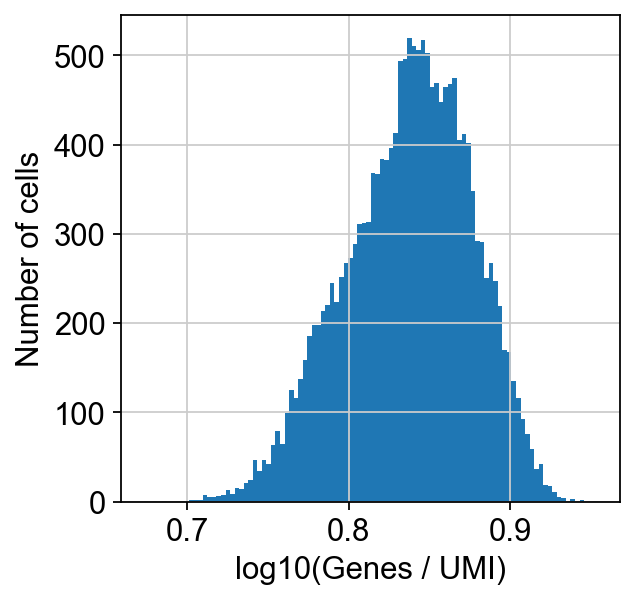

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(adata.obs["log10GenesPerUMI"], bins=100)
plt.xlabel("log10(Genes / UMI)")
plt.ylabel("Number of cells")
plt.show()


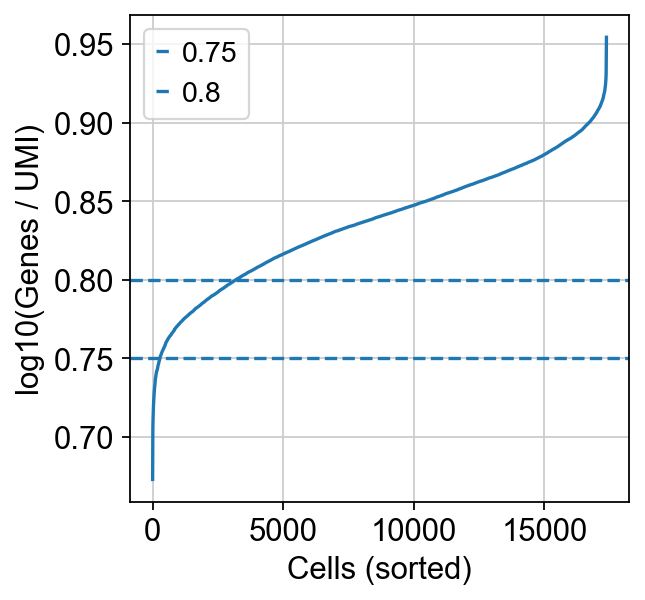

In [19]:
import numpy as np
import matplotlib.pyplot as plt

vals = np.sort(adata.obs["log10GenesPerUMI"].values)

plt.figure()
plt.plot(vals)
plt.xlabel("Cells (sorted)")
plt.ylabel("log10(Genes / UMI)")
plt.axhline(0.75, linestyle="--", label="0.75")
plt.axhline(0.8, linestyle="--", label="0.8")
plt.legend()
plt.show()


In [20]:
#Filter by Log10GenesPerUMI
adata = adata[adata.obs.log10GenesPerUMI >= 0.75,:]

In [21]:
#adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt <= 20, :]

## Run Demultiplexing

In [22]:
hashadata = hashadata[hashadata.obs.index.isin(adata.obs.index), :]

In [23]:
hashadata.var_names

Index(['AY1264_B0301', 'AY1267_B0302', 'AY1268_B0303', 'AY1422_B0304',
       'AY1271_B0305', 'AY1262_B0306', 'AY1263_B0307', 'AY1425_B0308',
       'AY1483_B0309', 'AY1484_B0310'],
      dtype='object')

In [24]:
hashCounts = pd.DataFrame(hashadata.X.todense(), columns=hashadata.var_names, index=adata.obs.index)

In [25]:
hashDisc = hashCounts.describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,0.99,0.999])
hashDisc

AY1264_B0301  AY1267_B0302  AY1268_B0303  AY1422_B0304  AY1271_B0305  \
count   16918.000000  16918.000000  16918.000000  16918.000000  16918.000000   
mean      395.202728    287.589020    262.166168    555.378174    246.257294   
std      2890.324219   1557.646484   1109.552612   2025.603149    713.407410   
min         0.000000      0.000000      0.000000      0.000000      0.000000   
10%        11.000000      8.000000      7.000000     12.000000      4.000000   
20%        14.000000     10.000000      9.000000     15.000000      5.000000   
30%        16.000000     12.000000     11.000000     18.000000      6.000000   
40%        18.000000     13.000000     13.000000     20.000000      8.000000   
50%        21.000000     15.000000     15.000000     23.000000      9.000000   
60%        25.000000     17.000000     17.000000     27.000000     11.000000   
70%        31.000000     20.000000     21.000000     34.000000     14.000000   
80%        60.000000     25.000000     28.000000     62.000000     36.000000   
90%      1260.900000     39.000000    287.300000   1203.000000    915.000000   
99%      5480.470000   7344.770000   5820.320000  10148.600000   3427.320000   
99.9%   10226.956000  18826.283000  12511.371000  22209.660000   6462.221000   
max    348662.000000  36317.000000  27222.000000  39530.000000   9101.000000   

       AY1262_B0306  AY1263_B0307  AY1425_B0308  AY1483_B0309  AY1484_B0310  
count  16918.000000  16918.000000  16918.000000  16918.000000  16918.000000  
mean      51.921505     72.313866    101.929192    129.806534    112.155518  
std      537.379089    431.043671    538.641663    561.034180    652.787720  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
10%        0.000000      1.000000     10.000000      6.000000      2.000000  
20%        1.000000      2.000000     12.000000      7.000000      3.000000  
30%        1.000000      3.000000     14.000000      9.000000      4.000000  
40%        2.000000      3.000000     16.000000     10.000000      5.000000  
50%        2.000000      4.000000     18.000000     12.000000      6.000000  
60%        3.000000      4.000000     20.000000     13.000000      8.000000  
70%        3.000000      5.000000     24.000000     16.000000     10.000000  
80%        4.000000      7.000000     32.000000     22.000000     14.000000  
90%        6.000000      9.000000     79.000000    189.000000    189.000000  
99%     1467.930000   2137.300000   1800.770000   2882.130000   2051.830000  
99.9%   9027.913000   5357.525000   8155.154000   6691.130000   5821.011000  
max    14964.000000  10610.000000  16155.000000  15530.000000  59378.000000

In [26]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
for hashName in hashadata.var_names:
    print(hashName)
    print(hashDisc.loc["90%",hashName])
    hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
hashIDs

AY1264_B0301
1260.9000000000033
AY1267_B0302
39.0
AY1268_B0303
287.3000000000011
AY1422_B0304
1203.0
AY1271_B0305
915.0
AY1262_B0306
6.0
AY1263_B0307
9.0
AY1425_B0308
79.0
AY1483_B0309
189.0
AY1484_B0310
189.0


/tmp/ipykernel_3285603/2942643048.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/tmp/ipykernel_3285603/2942643048.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/tmp/ipykernel_3285603/2942643048.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False  True  True]' has dtype incompatible with float32, please exp

AY1264_B0301  AY1267_B0302  AY1268_B0303  AY1422_B0304  \
AAACCCAAGCTCCGAC-1         False         False         False         False   
AAACCCAAGCTTTCCC-1         False         False         False         False   
AAACCCAAGGAATCGC-1         False         False         False          True   
AAACCCACAACAAGAT-1         False         False         False         False   
AAACCCACACAGTACT-1         False         False         False         False   
...                          ...           ...           ...           ...   
TTTGTTGTCATTGCTT-1         False         False         False         False   
TTTGTTGTCCCGTTCA-1         False         False         False         False   
TTTGTTGTCCGGCAAC-1         False         False         False         False   
TTTGTTGTCGAGCCTG-1         False         False          True         False   
TTTGTTGTCTAGCAAC-1         False         False          True         False   

                    AY1271_B0305  AY1262_B0306  AY1263_B0307  AY1425_B0308  \
AAACCCAAGCTCCGAC-1         False         False         False         False   
AAACCCAAGCTTTCCC-1         False          True          True         False   
AAACCCAAGGAATCGC-1         False         False         False         False   
AAACCCACAACAAGAT-1         False         False         False         False   
AAACCCACACAGTACT-1         False         False         False         False   
...                          ...           ...           ...           ...   
TTTGTTGTCATTGCTT-1         False         False         False         False   
TTTGTTGTCCCGTTCA-1         False         False          True         False   
TTTGTTGTCCGGCAAC-1         False         False         False         False   
TTTGTTGTCGAGCCTG-1         False         False         False         False   
TTTGTTGTCTAGCAAC-1         False         False         False         False   

                    AY1483_B0309  AY1484_B0310  
AAACCCAAGCTCCGAC-1         False         False  
AAACCCAAGCTTTCCC-1          True         False  
AAACCCAAGGAATCGC-1         False         False  
AAACCCACAACAAGAT-1         False          True  
AAACCCACACAGTACT-1         False         False  
...                          ...           ...  
TTTGTTGTCATTGCTT-1         False         False  
TTTGTTGTCCCGTTCA-1         False         False  
TTTGTTGTCCGGCAAC-1         False          True  
TTTGTTGTCGAGCCTG-1         False         False  
TTTGTTGTCTAGCAAC-1         False         False  

[16918 rows x 10 columns]

In [27]:
from matplotlib import pyplot as plt

In [28]:
hashCounts

AY1264_B0301  AY1267_B0302  AY1268_B0303  AY1422_B0304  \
AAACCCAAGCTCCGAC-1         770.0          27.0          10.0          38.0   
AAACCCAAGCTTTCCC-1          23.0          19.0          16.0          25.0   
AAACCCAAGGAATCGC-1          16.0           7.0          11.0        2938.0   
AAACCCACAACAAGAT-1           9.0          10.0          13.0          29.0   
AAACCCACACAGTACT-1          16.0          14.0          12.0          13.0   
...                          ...           ...           ...           ...   
TTTGTTGTCATTGCTT-1          14.0          12.0          40.0          17.0   
TTTGTTGTCCCGTTCA-1          12.0           7.0           2.0          14.0   
TTTGTTGTCCGGCAAC-1          24.0          14.0           8.0          43.0   
TTTGTTGTCGAGCCTG-1          10.0          32.0        6198.0          29.0   
TTTGTTGTCTAGCAAC-1          21.0          23.0        2352.0          22.0   

                    AY1271_B0305  AY1262_B0306  AY1263_B0307  AY1425_B0308  \
AAACCCAAGCTCCGAC-1           9.0           1.0           7.0          20.0   
AAACCCAAGCTTTCCC-1           9.0          20.0          15.0          15.0   
AAACCCAAGGAATCGC-1          12.0           3.0           8.0          12.0   
AAACCCACAACAAGAT-1          15.0           4.0           7.0          13.0   
AAACCCACACAGTACT-1           9.0           5.0           3.0           9.0   
...                          ...           ...           ...           ...   
TTTGTTGTCATTGCTT-1           4.0           0.0           1.0          11.0   
TTTGTTGTCCCGTTCA-1           2.0           1.0         211.0          16.0   
TTTGTTGTCCGGCAAC-1           5.0           1.0           1.0          23.0   
TTTGTTGTCGAGCCTG-1           6.0           3.0           1.0          18.0   
TTTGTTGTCTAGCAAC-1           5.0           4.0           5.0          23.0   

                    AY1483_B0309  AY1484_B0310  
AAACCCAAGCTCCGAC-1          24.0           9.0  
AAACCCAAGCTTTCCC-1        1252.0           4.0  
AAACCCAAGGAATCGC-1           5.0           6.0  
AAACCCACAACAAGAT-1          16.0        1241.0  
AAACCCACACAGTACT-1         171.0           5.0  
...                          ...           ...  
TTTGTTGTCATTGCTT-1          11.0           3.0  
TTTGTTGTCCCGTTCA-1           8.0           4.0  
TTTGTTGTCCGGCAAC-1          10.0         793.0  
TTTGTTGTCGAGCCTG-1           7.0           7.0  
TTTGTTGTCTAGCAAC-1          14.0          10.0  

[16918 rows x 10 columns]

In [29]:
plt.rcParams['figure.figsize'] = (4,4)

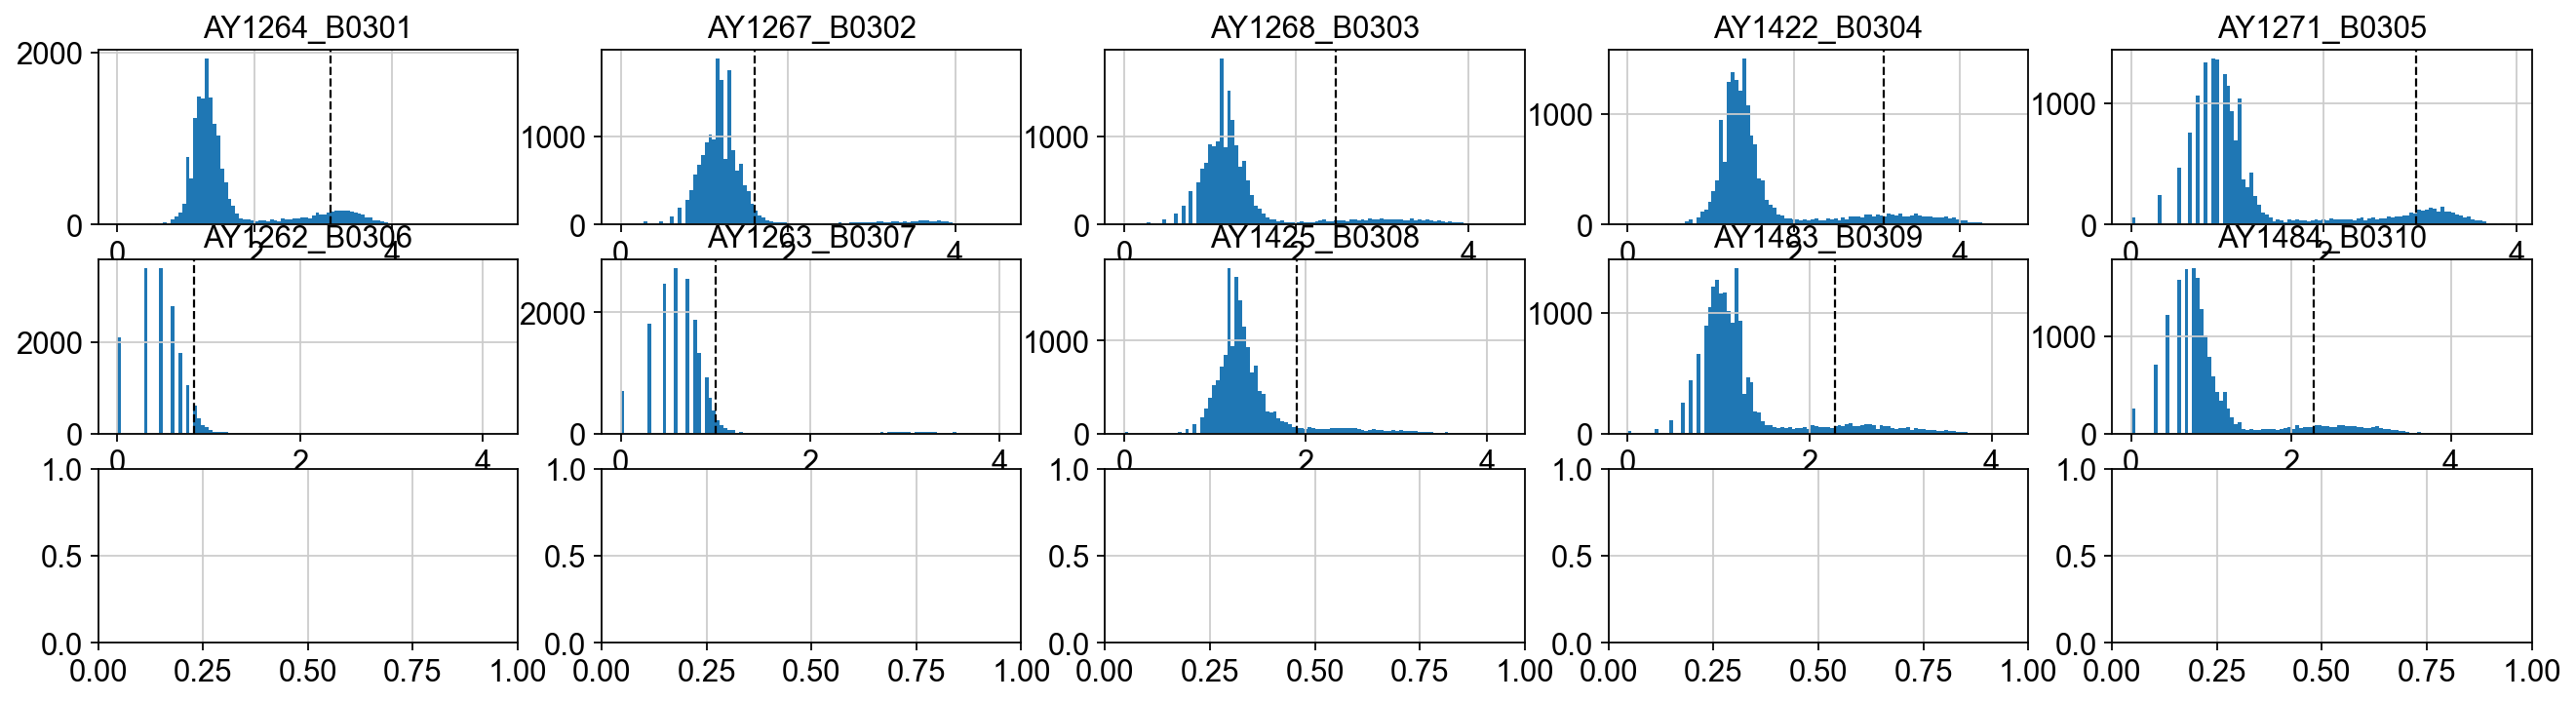

In [30]:
fig, axs = plt.subplots(3,5, figsize =(20, 5))

for i, hashName in enumerate(hashadata.var_names):
    hashCounts2 = np.log10(hashCounts[hashName]+1)
    axs[i//5,i%5].set_title(hashName)
    axs[i//5,i%5].hist(hashCounts2, bins = 100)
    axs[i//5,i%5].axvline(np.log10(int(hashDisc.loc["90%",hashName])+1), color='k', linestyle='dashed', linewidth=1)

#plt.rcParams["figure.figsize"] = (20,5)
plt.show()

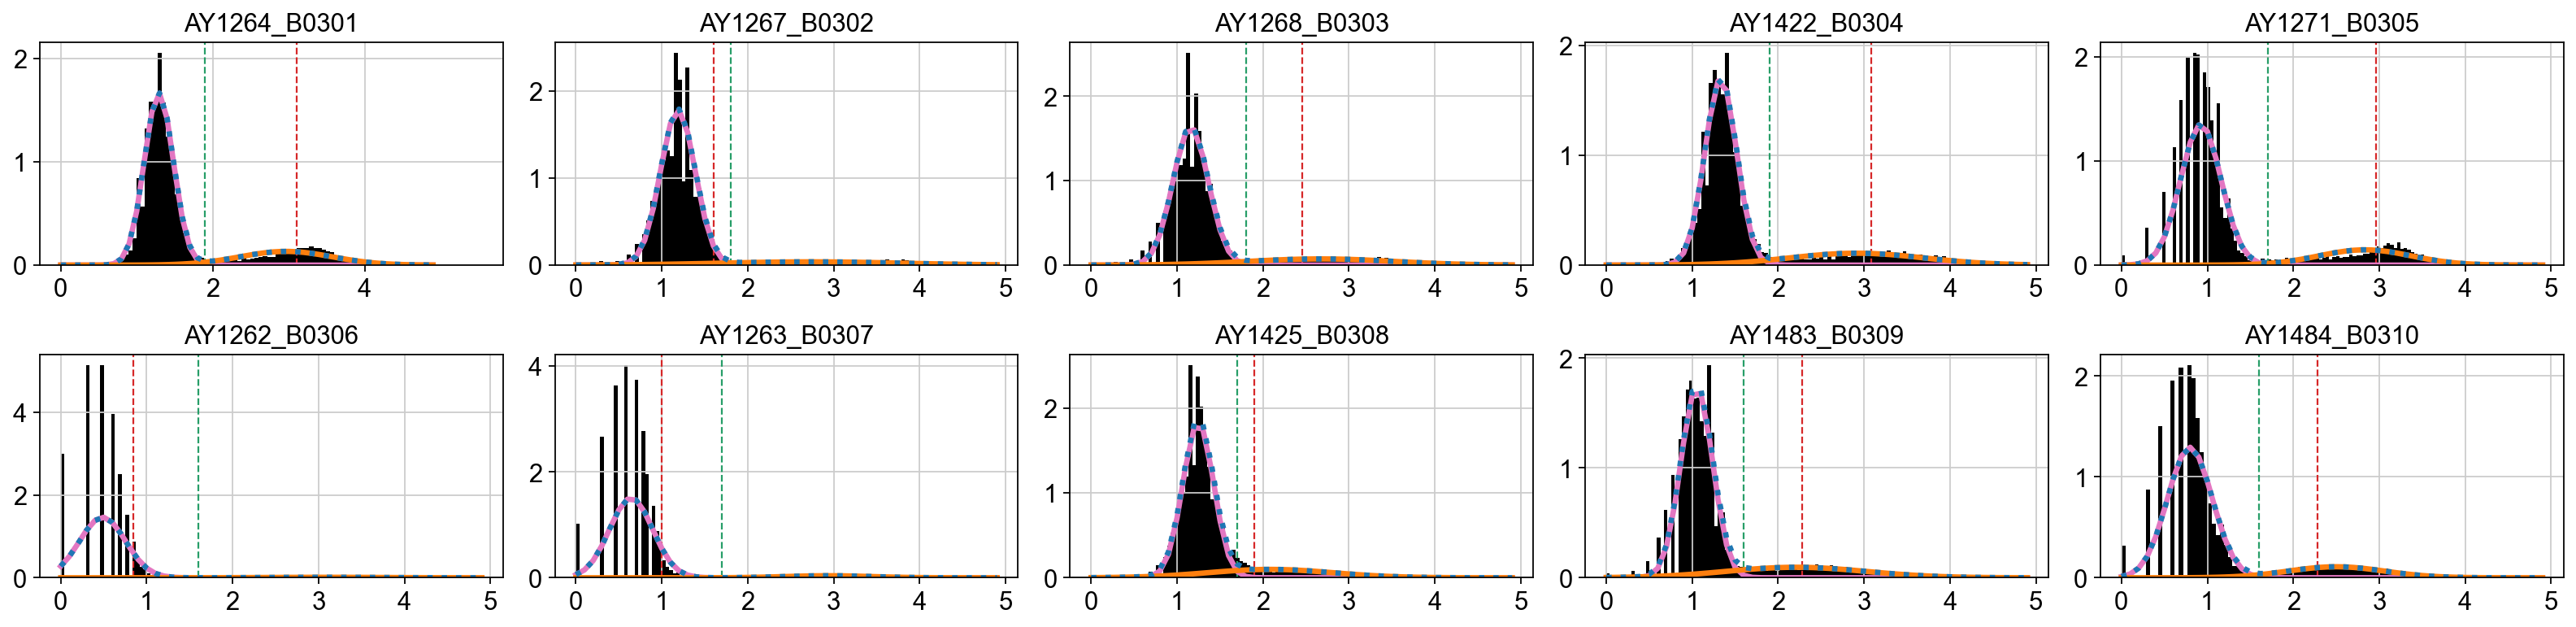

In [31]:
from sklearn.mixture import BayesianGaussianMixture
from scipy.stats import norm
fig, axs = plt.subplots(2,5, figsize =(20, 5))
dfHashBoundry = pd.DataFrame(np.zeros(len(hashadata.var_names)),hashadata.var_names, columns=["boundry"])
gmm = BayesianGaussianMixture(n_components=2, random_state=250,init_params='k-means++')
binEx = np.arange(0,5,5/100).reshape(-1,1)

for i, hashName in enumerate(hashadata.var_names):
    hashCount = np.array(np.log10(hashCounts[hashName]+1)).reshape(-1, 1)
    fitGMM = gmm.fit(hashCount)
    mean = fitGMM.means_  
    covs  = fitGMM.covariances_
    weights = fitGMM.weights_
  
    fitGmmBound = fitGMM.predict(binEx)

    if mean[0][0] < mean[1][0]:
        left_idx, right_idx = 0, 1
    else:
        left_idx, right_idx = 1, 0

    
    x_axis = np.arange(0, 5, 0.1)
    
    y_left = norm.pdf(x_axis, float(mean[left_idx][0]), np.sqrt(float(covs[left_idx][0][0]))) * weights[left_idx]
    y_right = norm.pdf(x_axis, float(mean[right_idx][0]), np.sqrt(float(covs[right_idx][0][0]))) * weights[right_idx]

    hashBoundry = False #binEx[np.where(fitGmmBound == 1)[0][0]][0]  

    diff = y_right - y_left
    crossings = np.where(np.diff(np.sign(diff)) > 0)[0]  # where right overtakes left
    
    if len(crossings) > 0:
        # Take the first crossing where right becomes dominant
        idx = crossings[0]
        hashBoundry = x_axis[idx + 1]  # slightly to the right
    else:
        # If no intersection found, fall back to right mean or a fixed value
        hashBoundry = float(mean[right_idx][0])

    
    naiveBoundry = np.log10(int(hashDisc.loc["90%",hashName])+1)
    
    dfHashBoundry.loc[hashName] = hashBoundry
    
    # Plot 2
    axs[i//5,i%5].set_title(hashName)
    axs[i//5,i%5].axvline(naiveBoundry, c='C3', linestyle='dashed', linewidth=1) #red
    axs[i//5,i%5].axvline(hashBoundry, c='C2', linestyle='dashed', linewidth=1)  #green
    axs[i//5,i%5].hist(hashCount, density=True, color='black', bins=100)        
    axs[i//5,i%5].plot(x_axis, y_left, lw=3, c='C6')                            #pink
    axs[i//5,i%5].plot(x_axis, y_right, lw=3, c='C1')                            #orange
    axs[i//5,i%5].plot(x_axis, y_left+y_right, lw=3, c='C0', ls=':')            #dotted blue
    
plt.tight_layout(pad=1.0)
#plt.rcParams["figure.figsize"] = (20,5)
plt.show()

In [32]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
#set manual minimum threshold to be 1
for hashName in hashadata.var_names:
    print(hashName)
    print(dfHashBoundry.loc[hashName].values[0])
    #manually set minimum threshold to 1 given poor HashData
    if (dfHashBoundry.loc[hashName].values[0] < 1):
        dfHashBoundry.loc[hashName].values[0] = 1
    print(dfHashBoundry.loc[hashName].values[0])
    hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
#hashIDs

AY1264_B0301
1.9000000000000001
1.9000000000000001
AY1267_B0302
1.8
1.8
AY1268_B0303
1.8
1.8
AY1422_B0304
1.9000000000000001
1.9000000000000001
AY1271_B0305
1.7000000000000002
1.7000000000000002
AY1262_B0306
1.6
1.6
AY1263_B0307
1.7000000000000002
1.7000000000000002
AY1425_B0308
1.7000000000000002
1.7000000000000002
AY1483_B0309
1.6
1.6
AY1484_B0310
1.6
1.6


/tmp/ipykernel_3285603/4060069450.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/tmp/ipykernel_3285603/4060069450.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/tmp/ipykernel_3285603/4060069450.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False  True  True]' ha

In [33]:
classification = np.empty(len(adata), dtype="object")
i = 0
for cellBar, hashBool in hashIDs.iterrows():
    numHashes = sum(hashBool)
    if (numHashes == 1):
        classif = hashID[hashBool.values].values[0]
    elif (numHashes > 1):
        classif = "doublet"
    else:
        classif = "negative"
    classification[i] = classif
    i = i + 1
    #break

In [34]:
adata.obs["Classification"] = classification
hashadata.obs["Classification"] = classification
adata.obs["Classification"].value_counts()

/tmp/ipykernel_3285603/4135005838.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["Classification"] = classification
/tmp/ipykernel_3285603/4135005838.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  hashadata.obs["Classification"] = classification


Classification
doublet         4489
AY1271_B0305    1904
AY1264_B0301    1784
AY1422_B0304    1720
AY1483_B0309    1342
AY1484_B0310    1339
AY1268_B0303    1186
AY1425_B0308    1024
negative         894
AY1267_B0302     651
AY1263_B0307     443
AY1262_B0306     142
Name: count, dtype: int64

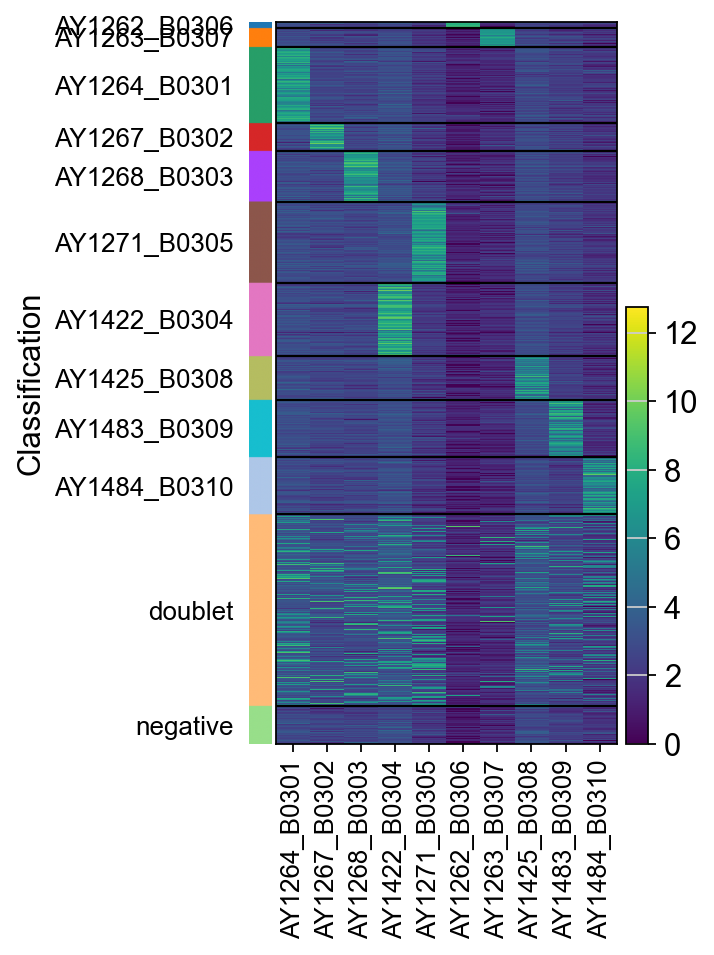

In [35]:
#output visualization of hashing
sc.pl.heatmap(hashadata, hashadata.var_names, groupby="Classification", log=True)#, save = f"_{figName}_hash.png")

## Set transgenes counts

(array([1.6791e+04, 8.7000e+01, 2.5000e+01, 8.0000e+00, 5.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0.        ,  1.20000005,  2.4000001 ,  3.60000014,  4.80000019,
         6.        ,  7.20000029,  8.40000057,  9.60000038, 10.80000019,
        12.        ]),
 <BarContainer object of 10 artists>)

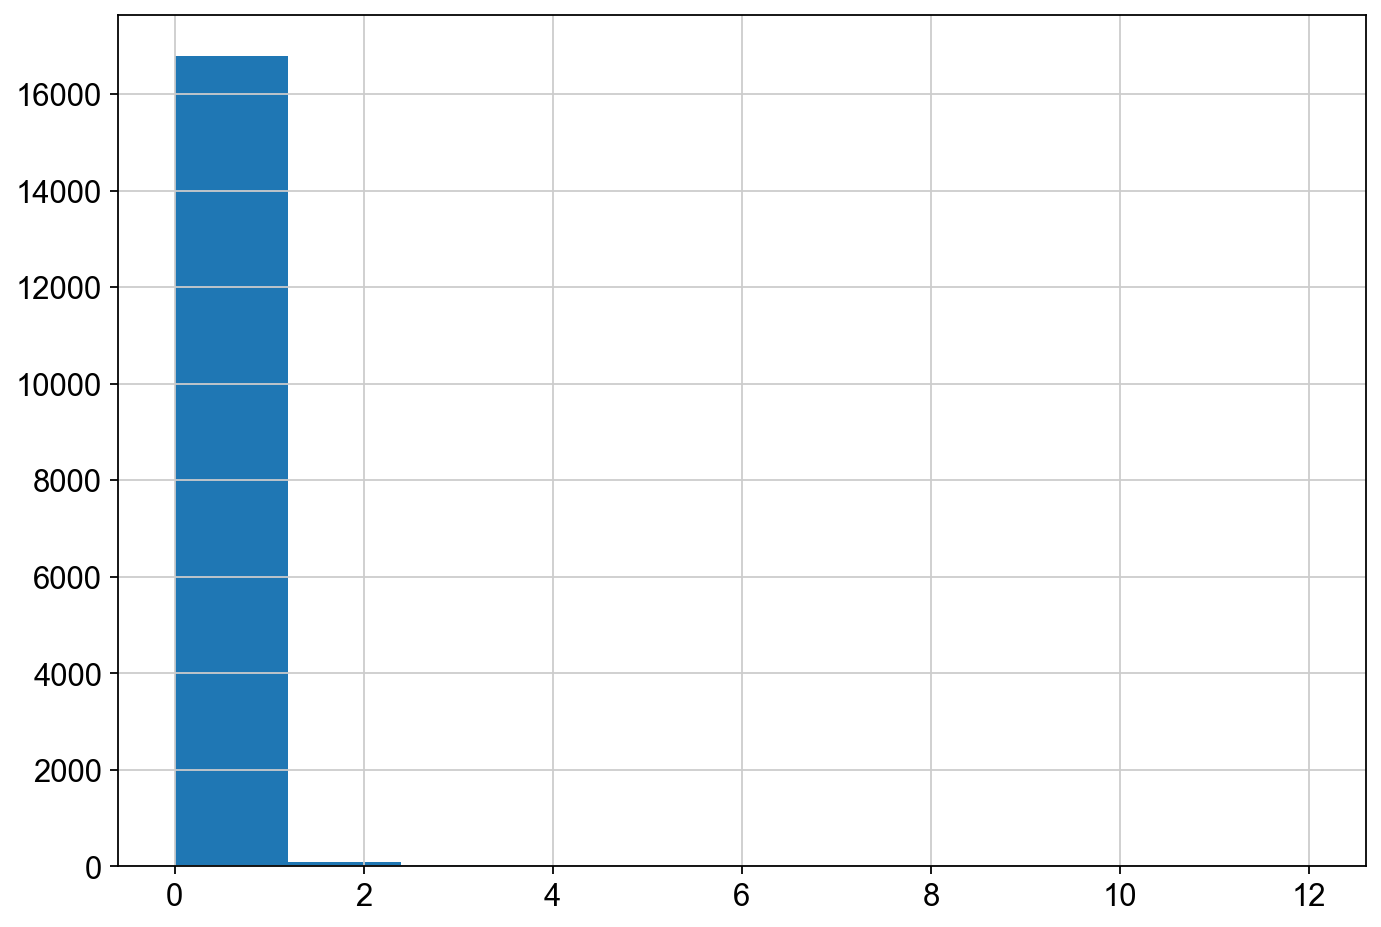

In [36]:
#Remove any cell with PTPRC counts
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(adata.X[:,adata.var.index.isin(['Cre'])].toarray())
#ax.axvline(np.log10(int(hashDisc.loc["90%",hashName])+1), color='k', linestyle='dashed', linewidth=1)
# Show plot
#adata.obs['shRen'] = 0

#adata.obs['shRenilla'][adata.X[:,adata.var.index.isin(['shRenilla'])] >0] #= adata.X[:,adata.var.index.isin(['shRenilla'])]

In [37]:
adata.obs['Cre_count'] = adata.X[:,adata.var.index.isin(['Cre'])].toarray()

## Remove doublets, negative cells

In [38]:
adata = adata[~adata.obs['Classification'].isin(['doublet','negative']),:]

In [39]:
adata.obs.Classification.value_counts()

Classification
AY1271_B0305    1904
AY1264_B0301    1784
AY1422_B0304    1720
AY1483_B0309    1342
AY1484_B0310    1339
AY1268_B0303    1186
AY1425_B0308    1024
AY1267_B0302     651
AY1263_B0307     443
AY1262_B0306     142
Name: count, dtype: int64

## Set Groups

In [40]:
#Set shRNA groups
adata.obs['Group'] = 'Cre'
adata.obs['Group'][adata[adata.obs.Classification.isin(['AY1262_B0306','AY1263_B0307','AY1425_B0308',
                                                        'AY1483_B0309','AY1484_B0310']),:].obs.index] = 'IkbSR-Cre'

/tmp/ipykernel_3285603/4004678245.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Group'] = 'Cre'
/tmp/ipykernel_3285603/4004678245.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [41]:
adata.obs[['Classification','Group']].value_counts()

Classification  Group    
AY1271_B0305    Cre          1904
AY1264_B0301    Cre          1784
AY1422_B0304    Cre          1720
AY1483_B0309    IkbSR-Cre    1342
AY1484_B0310    IkbSR-Cre    1339
AY1268_B0303    Cre          1186
AY1425_B0308    IkbSR-Cre    1024
AY1267_B0302    Cre           651
AY1263_B0307    IkbSR-Cre     443
AY1262_B0306    IkbSR-Cre     142
Name: count, dtype: int64

## Make backup copy of raw counts

In [42]:
adata.layers['counts']=adata.X.copy()

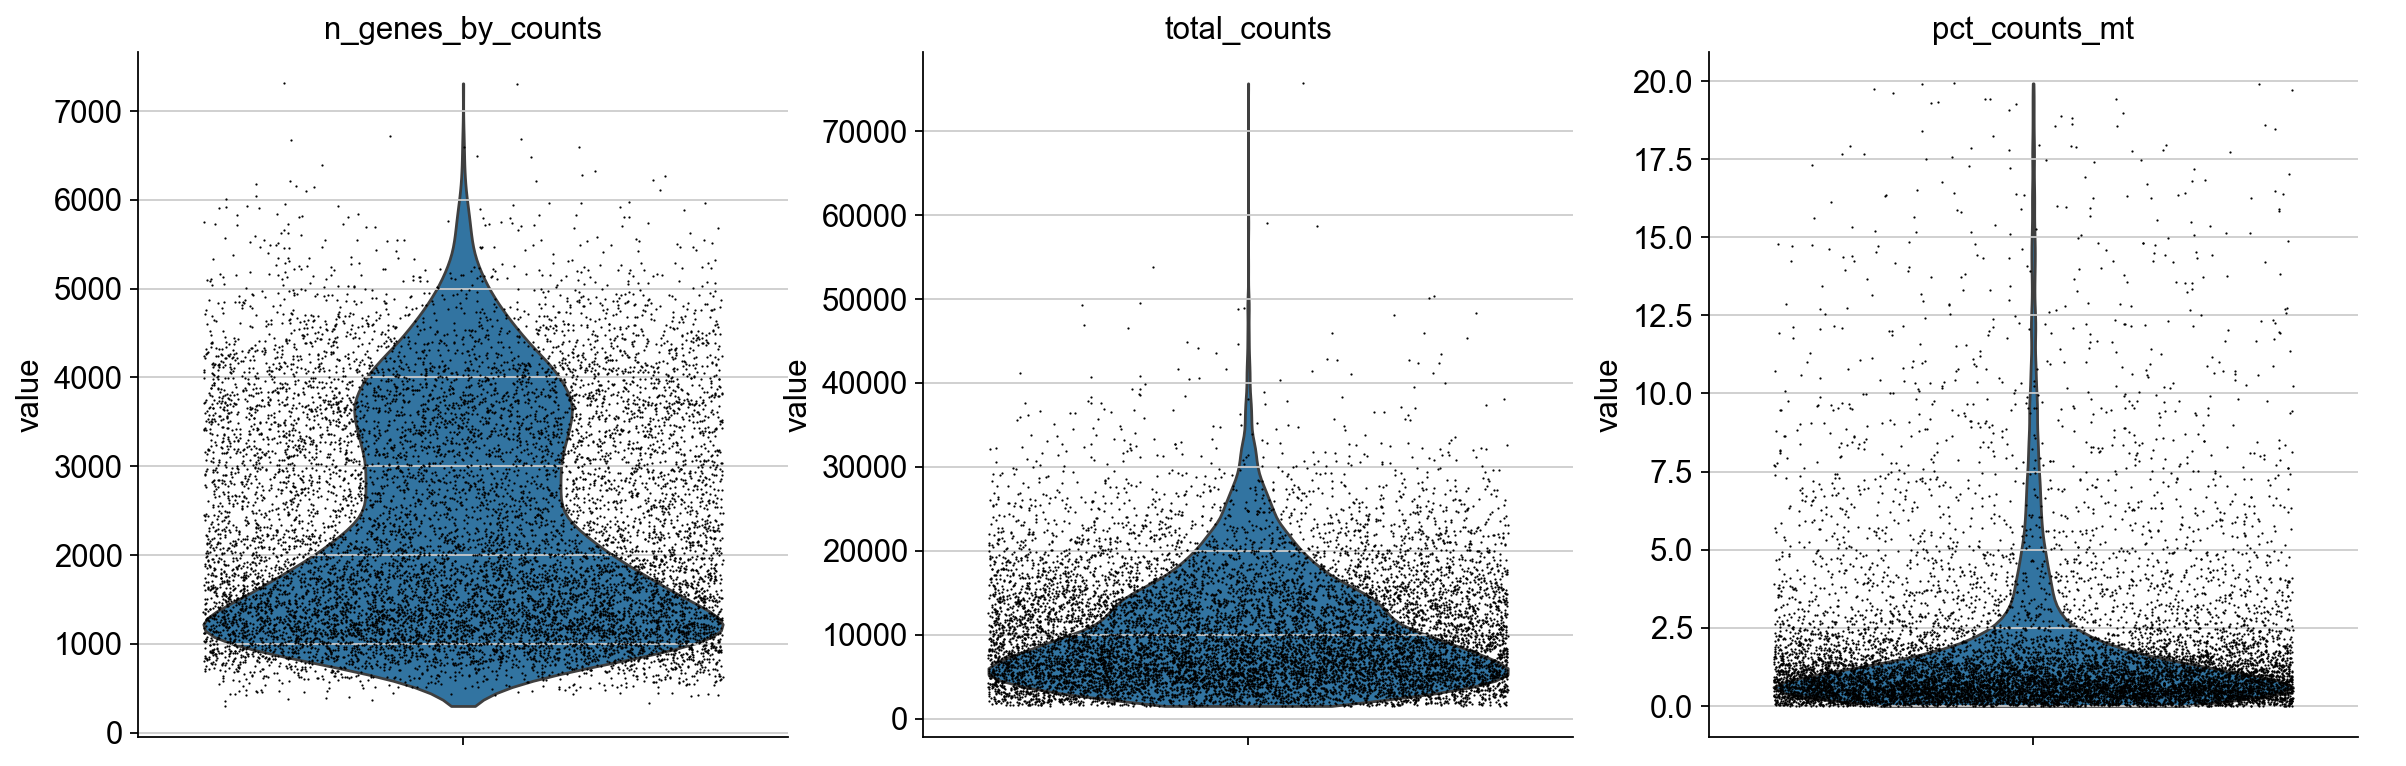

In [43]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, rotation=90)

## Continue preprocessing

In [44]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


Logarithmize the data:

In [45]:
sc.pp.log1p(adata)

In [46]:
sc.pp.highly_variable_genes(adata) #batch_key=Classification

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


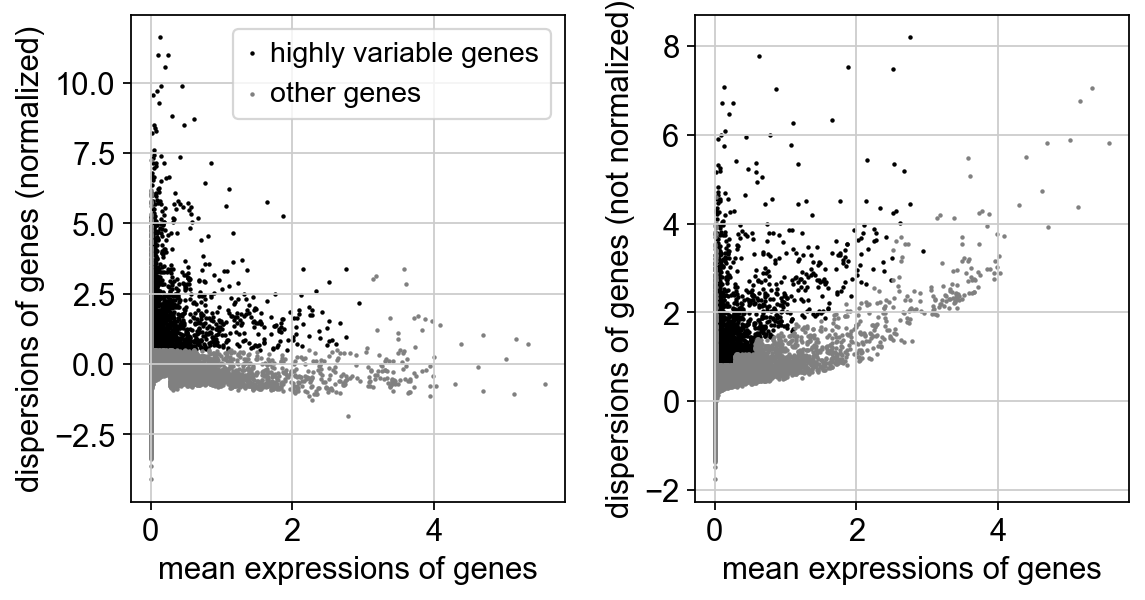

In [47]:
sc.pl.highly_variable_genes(adata)

In [48]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['Ikbsr-FLAG'] = False
adata.var.highly_variable['Cre'] = False
adata.var.highly_variable['mKate2'] = False

/tmp/ipykernel_3285603/2033711310.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['Ikbsr-FLAG'] = False
/tmp/ipykernel_3285603/2033711310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [49]:
samples

['AY1264_B0301',
 'AY1267_B0302',
 'AY1268_B0303',
 'AY1422_B0304',
 'AY1271_B0305',
 'AY1262_B0306',
 'AY1263_B0307',
 'AY1425_B0308',
 'AY1483_B0309',
 'AY1484_B0310']

In [50]:
adata.raw = adata

In [51]:
adata.write('write/JC2499_allmice.h5ad', compression='gzip')

In [52]:
sc.pp.scale(adata, max_value=10)

/home/chanj2/part2a/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


## Principal component analysis

In [53]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=100)

computing PCA
    with n_comps=100
    finished (0:00:05)


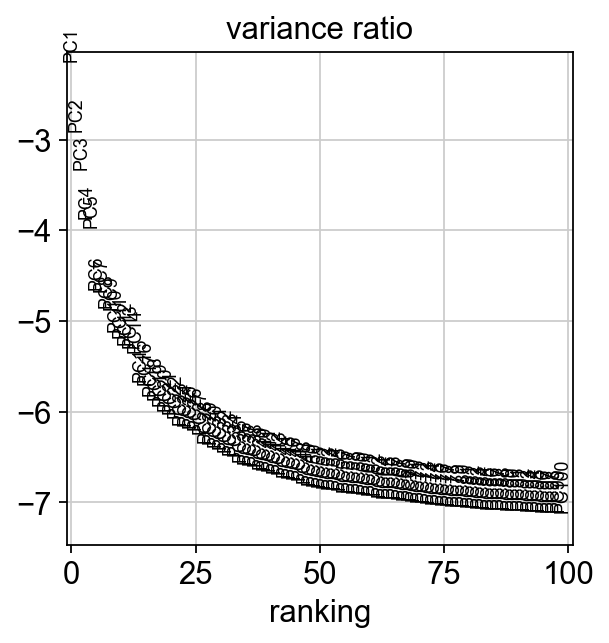

In [54]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=100)

In [55]:
adata.write(results_file, compression='gzip')

In [56]:
adata

AnnData object with n_obs × n_vars = 11535 × 25427
    obs: 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log10GenesPerUMI', 'Classification', 'Cre_count', 'Group'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

## Computing the neighborhood graph

In [57]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50


/home/chanj2/part2a/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:19)


## Embedding the neighborhood graph

In [58]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:15)


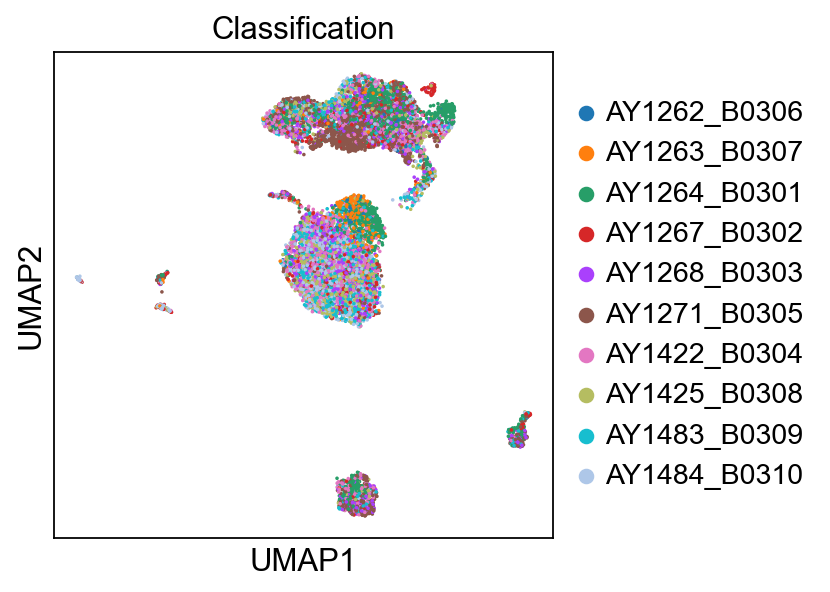

In [59]:
sc.pl.umap(adata, color=['Classification'])

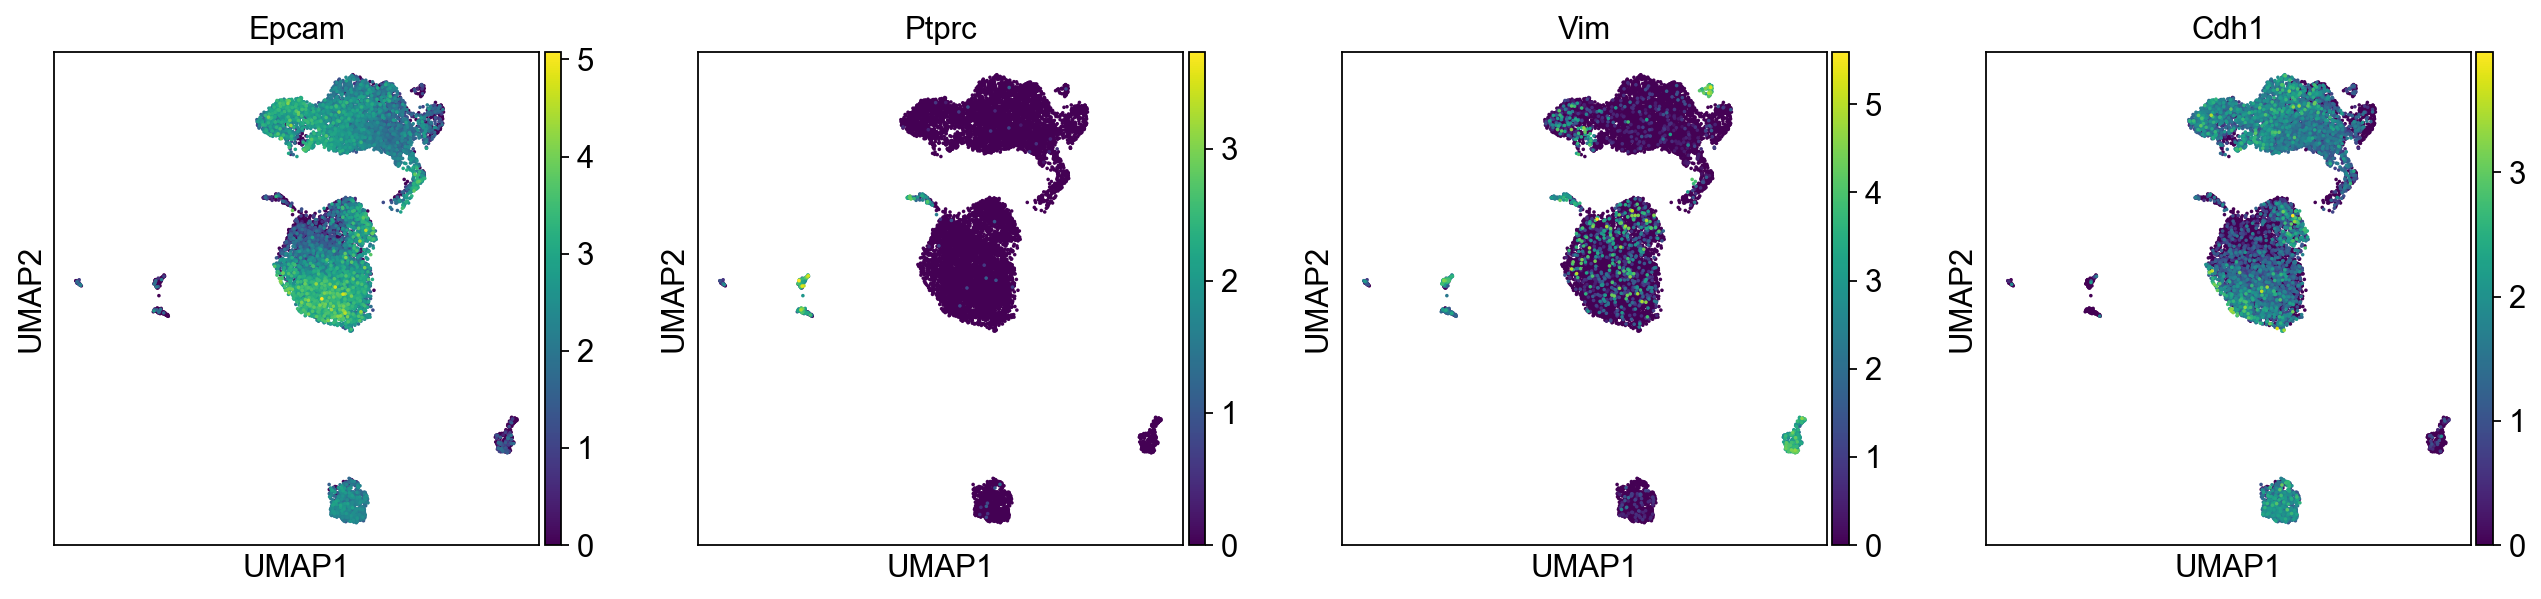

In [60]:
sc.pl.umap(adata, color=['Epcam', 'Ptprc','Vim', 'Cdh1',])#'Cdh2'

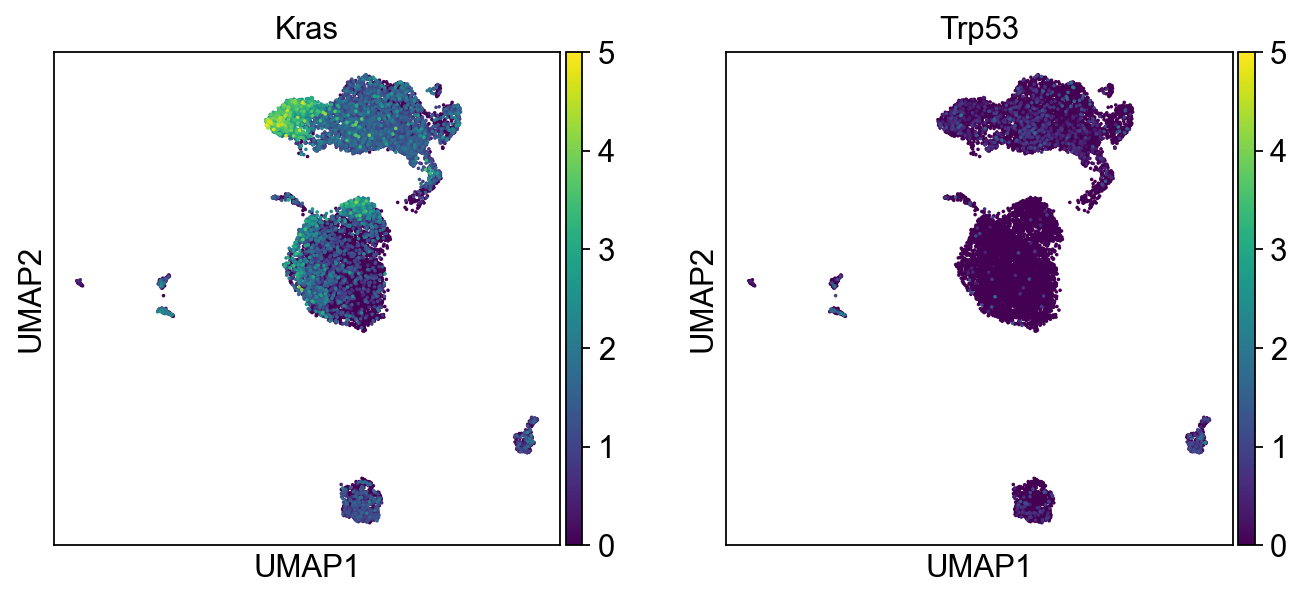

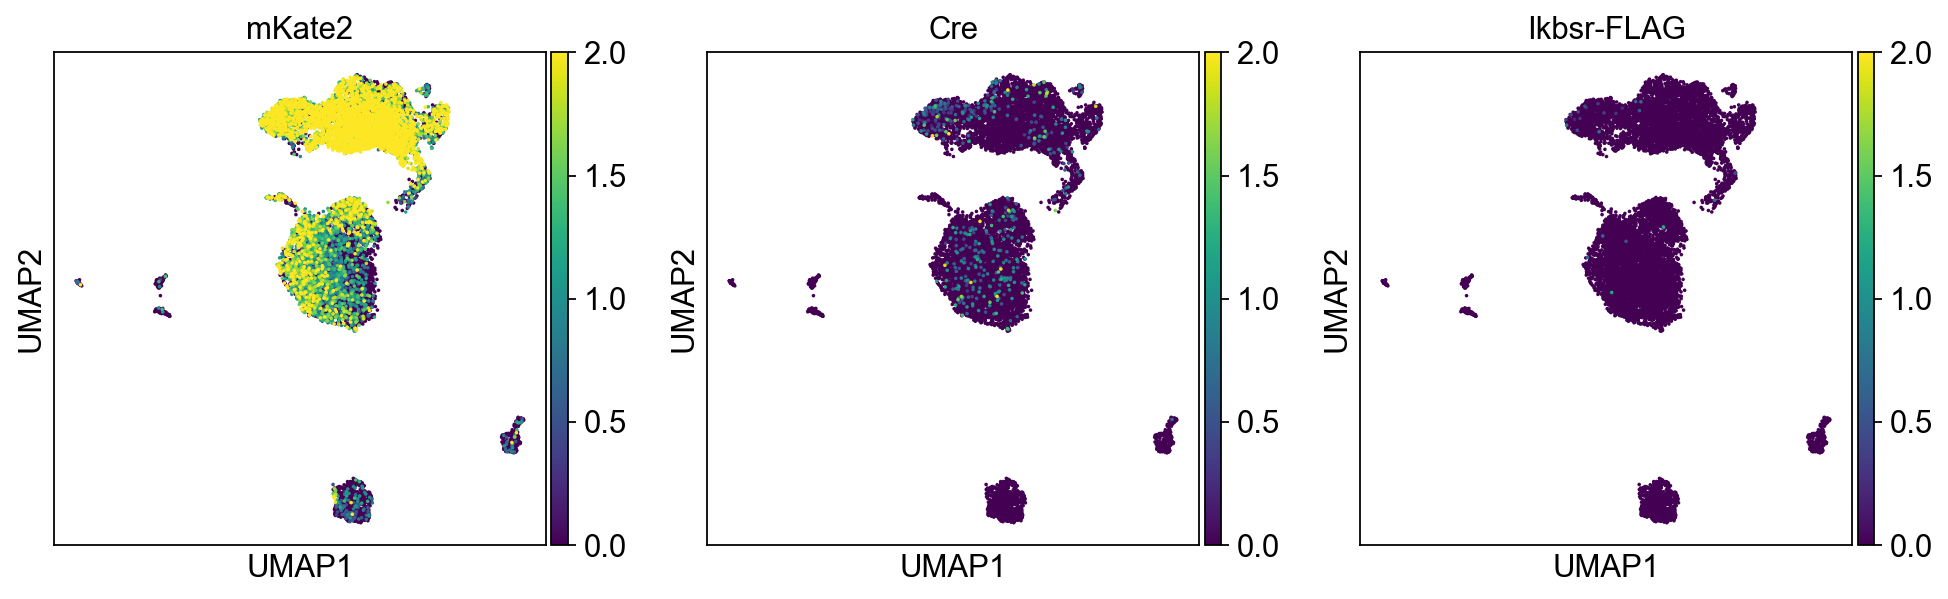

In [61]:
sc.pl.umap(adata, color=['Kras','Trp53'], vmax=5)
sc.pl.umap(adata, color=['mKate2','Cre','Ikbsr-FLAG'], vmax=2)

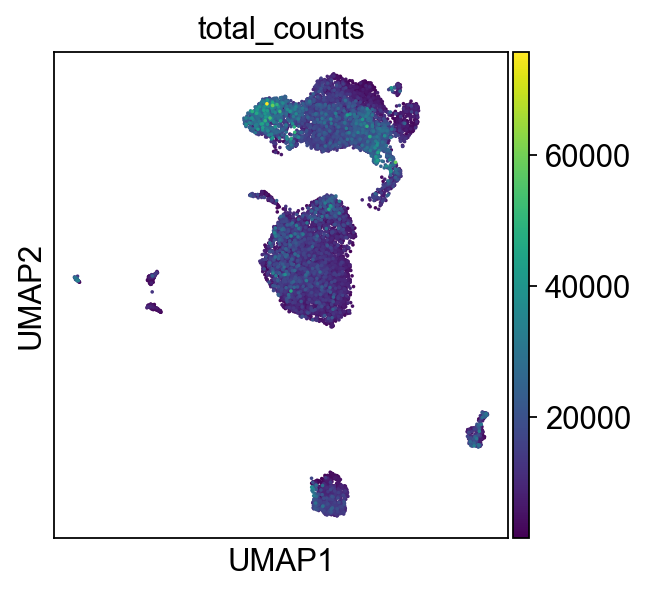

In [62]:
sc.pl.umap(adata, color=['total_counts'])

In [63]:
# Score Cluster 5 cells
import csv
clusters = {}
clusterkeys = []
HPCS = False

def resetClusters(hpcs = 'cell2020'):
    clusters = {}
    clusterkeys = []
    HPCS = False
    try:
        if hpcs == 'cell2020':         
            with open('../../common_files/clusters_cell2020.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                for row in csvreader:
                    clusters[row[0]] = [x for x in row[1:] if x != '']
            for i in range(1,13):
                #if i == 9: continue
                clusterkeys.append('Cluster %i' % i)
            HPCS = 'Cluster 5'
        elif hpcs == 'cell2020_no_Slc4a11':         
            with open('../../common_files/clusters_cell2020.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                for row in csvreader:
                    clusters[row[0]] = [x for x in row[1:] if x != '']   
                    if 'Slc4a11' in clusters[row[0]]:
                        clusters[row[0]].remove('Slc4a11')
                        print("Slc4a11 removed")
            for i in range(1,13):
                #if i == 9: continue
                clusterkeys.append('Cluster %i' % i)
            HPCS = 'Cluster 5'
        else:
            raise ValueError
    except ValueError:
        print("%s is an invalid choice" % hpcs)
        raise
    return (clusters, clusterkeys, HPCS)

(clusters, clusterkeys, HPCS) = resetClusters('cell2020')

In [64]:
def scoreAndPlot(ad, excludeList = None, groupby="Classification",rotation=90,numgenes=25):
    #cmap = 'Reds' #colormap
    cmap = 'jet' #colormap
    if excludeList == None:
        for i in clusterkeys:
            sc.tl.score_genes(ad, clusters[i][0:numgenes],score_name="%s" % i)  
        #sc.tl.score_genes(ad, clusters['Highly_mixed'],score_name="Highly_mixed")
  
        sc.pl.umap(ad, color=clusterkeys, color_map=cmap)
        sc.pl.dotplot(ad, clusterkeys, groupby=groupby, swap_axes=True)

In [65]:
from scipy.stats import ranksums

def HPCSViolinPlot(ad, cluster='0', groupby='leiden', score='Cluster5', save=None, singleGene=False):
    ad.obs['Cl5'] = 'not HPCS'
    ad.obs.loc[ad.obs[groupby].isin([cluster]), 'Cl5'] = 'HPCS'

    if singleGene:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray(),ad[~ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray())[1]
        #sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)
    else:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])].obs[score],ad[ad.obs['Cl5'].isin(['not HPCS'])].obs[score])[1]
    sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)

computing score 'Cluster 1'
    finished: added
    'Cluster 1', score of gene set (adata.obs).
    846 total control genes are used. (0:00:00)
computing score 'Cluster 2'
    finished: added
    'Cluster 2', score of gene set (adata.obs).
    794 total control genes are used. (0:00:00)
computing score 'Cluster 3'
    finished: added
    'Cluster 3', score of gene set (adata.obs).
    696 total control genes are used. (0:00:00)
computing score 'Cluster 4'
    finished: added
    'Cluster 4', score of gene set (adata.obs).
    798 total control genes are used. (0:00:00)
computing score 'Cluster 5'
    finished: added
    'Cluster 5', score of gene set (adata.obs).
    843 total control genes are used. (0:00:00)
computing score 'Cluster 6'
       'Ldha-ps2'],
      dtype='object')
    finished: added
    'Cluster 6', score of gene set (adata.obs).
    946 total control genes are used. (0:00:00)
computing score 'Cluster 7'
    finished: added
    'Cluster 7', score of gene set (adata.obs)

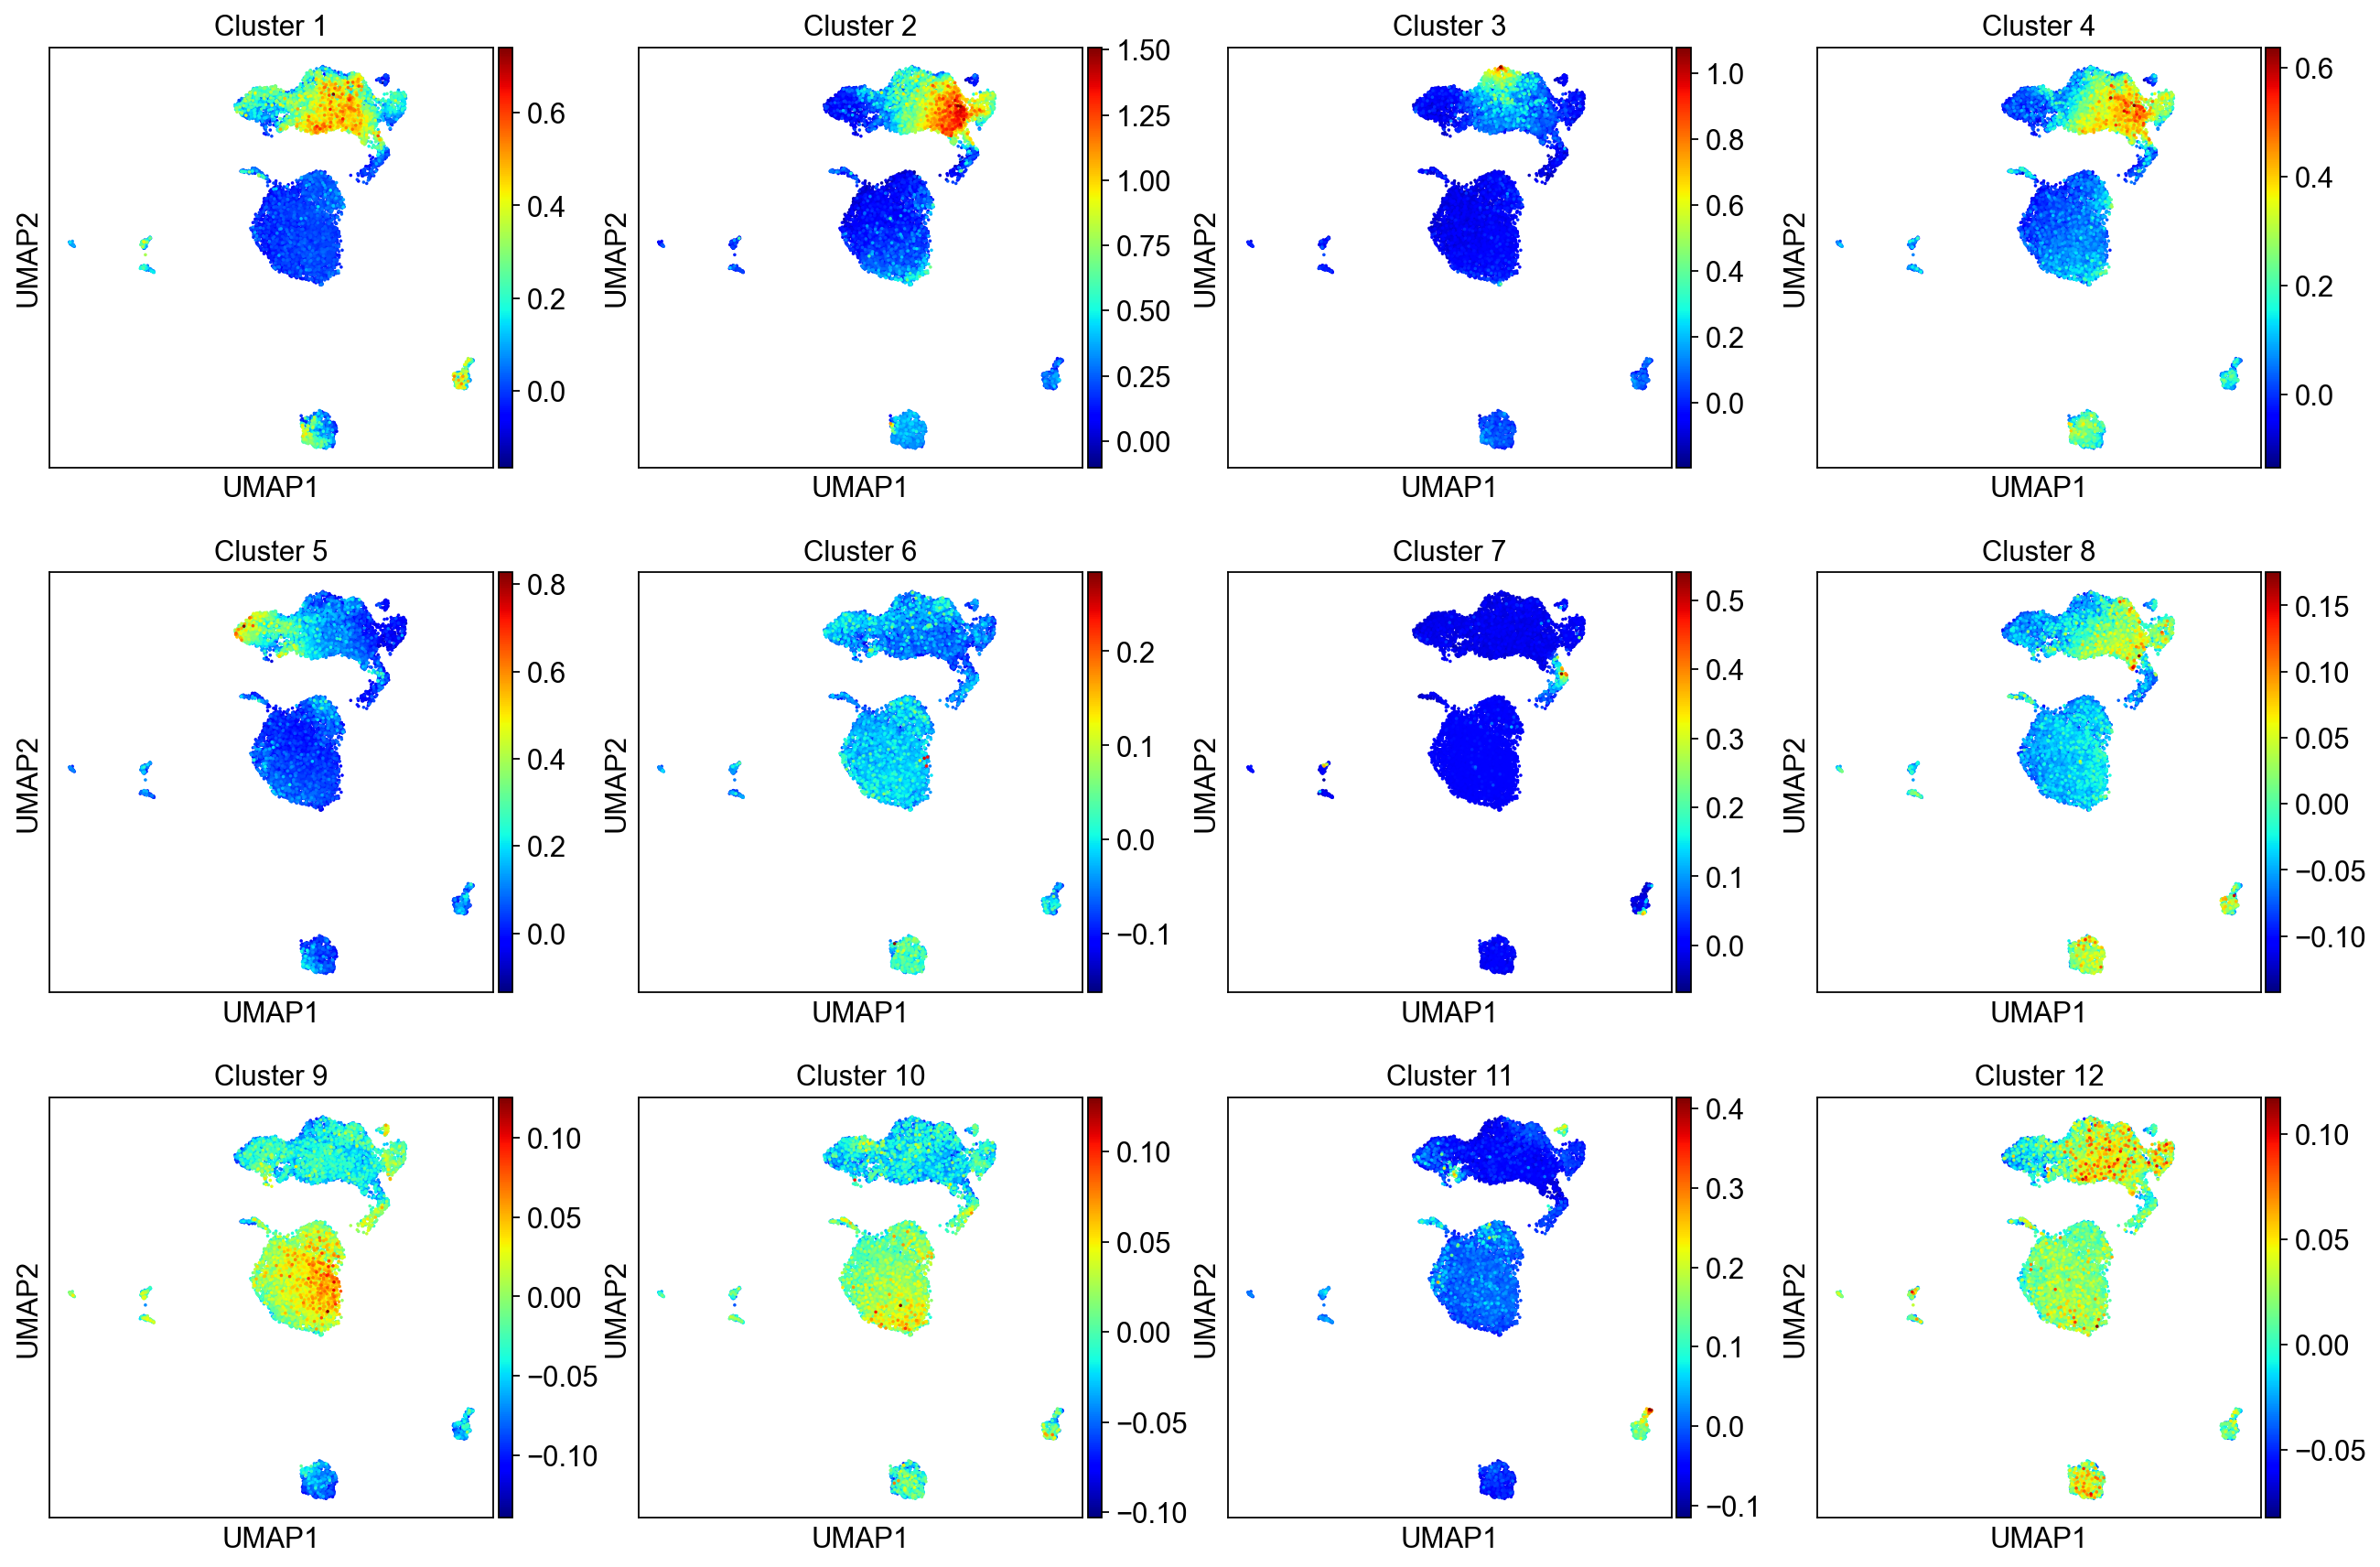

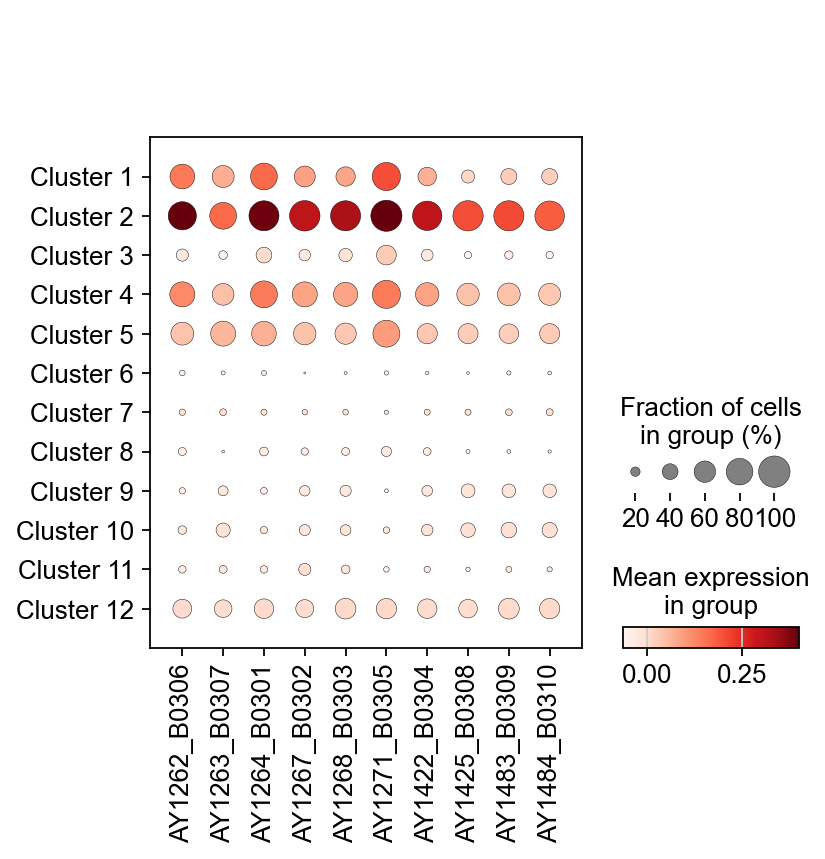

In [66]:
scoreAndPlot(adata,numgenes=100)

## Clustering the neighborhood graph

In [71]:
#sc.tl.leiden(adata, resolution=0.30)
sc.tl.leiden(adata, resolution=0.15)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


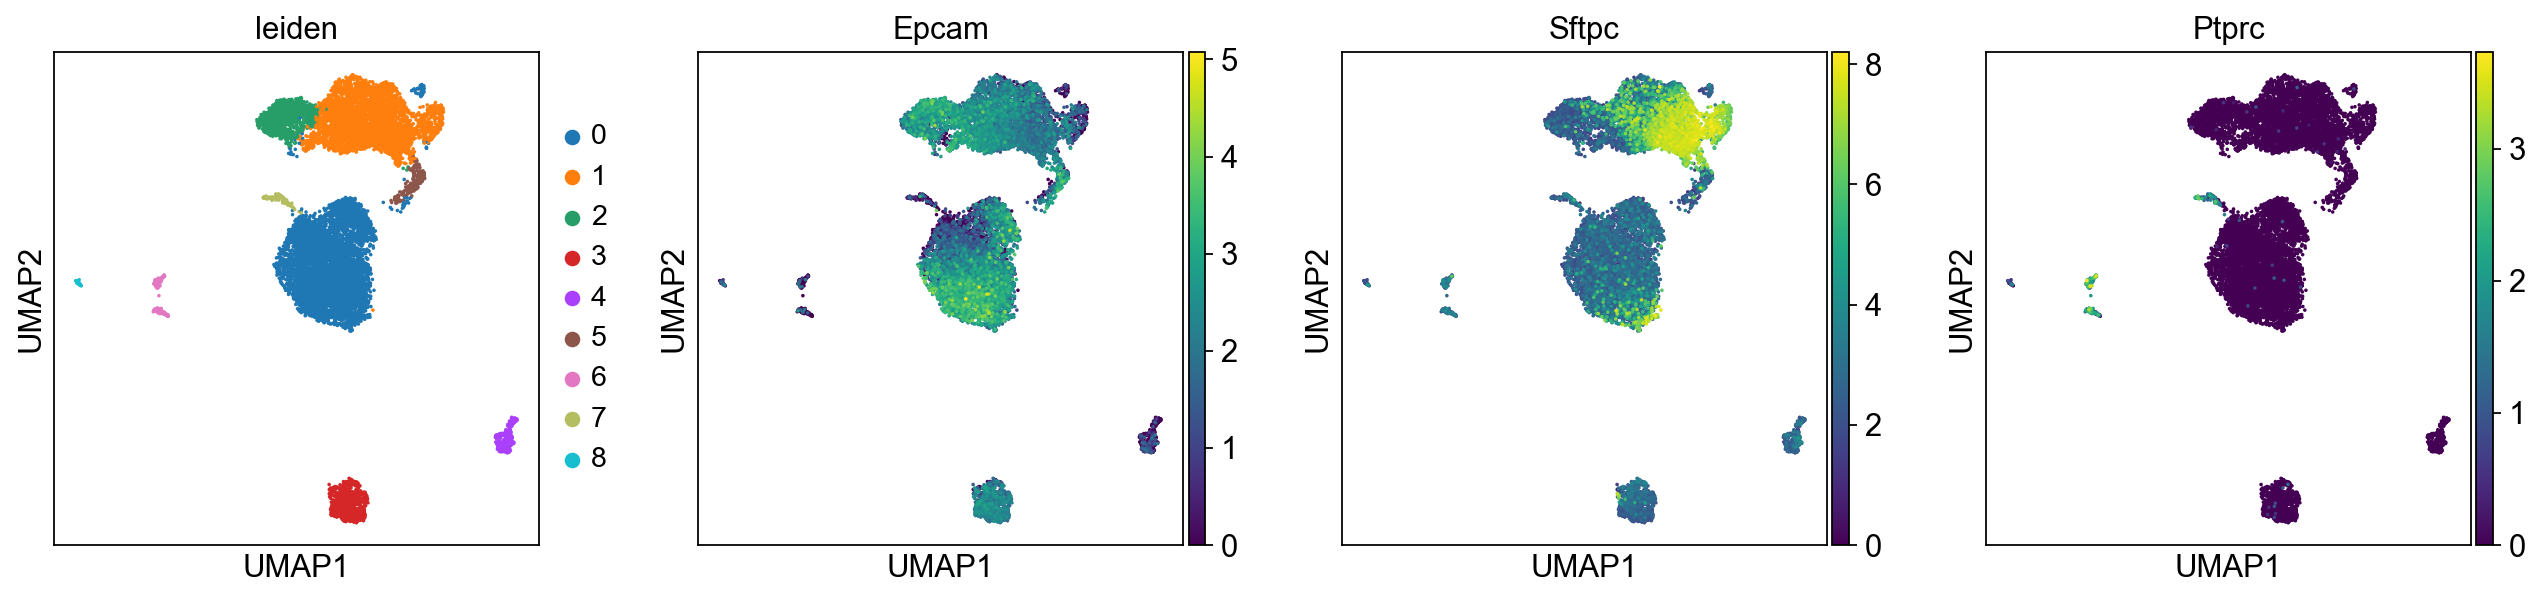

(None,)

In [72]:
sc.pl.umap(adata, color=['leiden', 'Epcam', 'Sftpc', # Tumor cells
                         'Ptprc']), #immune
                         # 'Cd3e', 'Cd4', 'Cd8a', #T cell
                         # 'Cd19', 'Ms4a1', 'Cd22', # B cell
                         # #'Itgax', 'Il3ra', # Dendritic Cell
                         # 'Ncam1',# 'Ncr1', # NK Cell
                         # 'Cd34', # Hematopoetic stem cell
                         # #'Cd14', 'Cd33', # macrophage
                         # #'Ceacam8' # Granulocyte
                         # 'Itga2b', 'Itgb3', 'Selp', #platelet
                         # #'Gypa',  # erythrocyte
                         # #'Mcam', 'Vcam1', 'Pecam1', 'Sele', # endothelial cell
                         # 'Cd109', 'Wnt5a', 'Kras'])

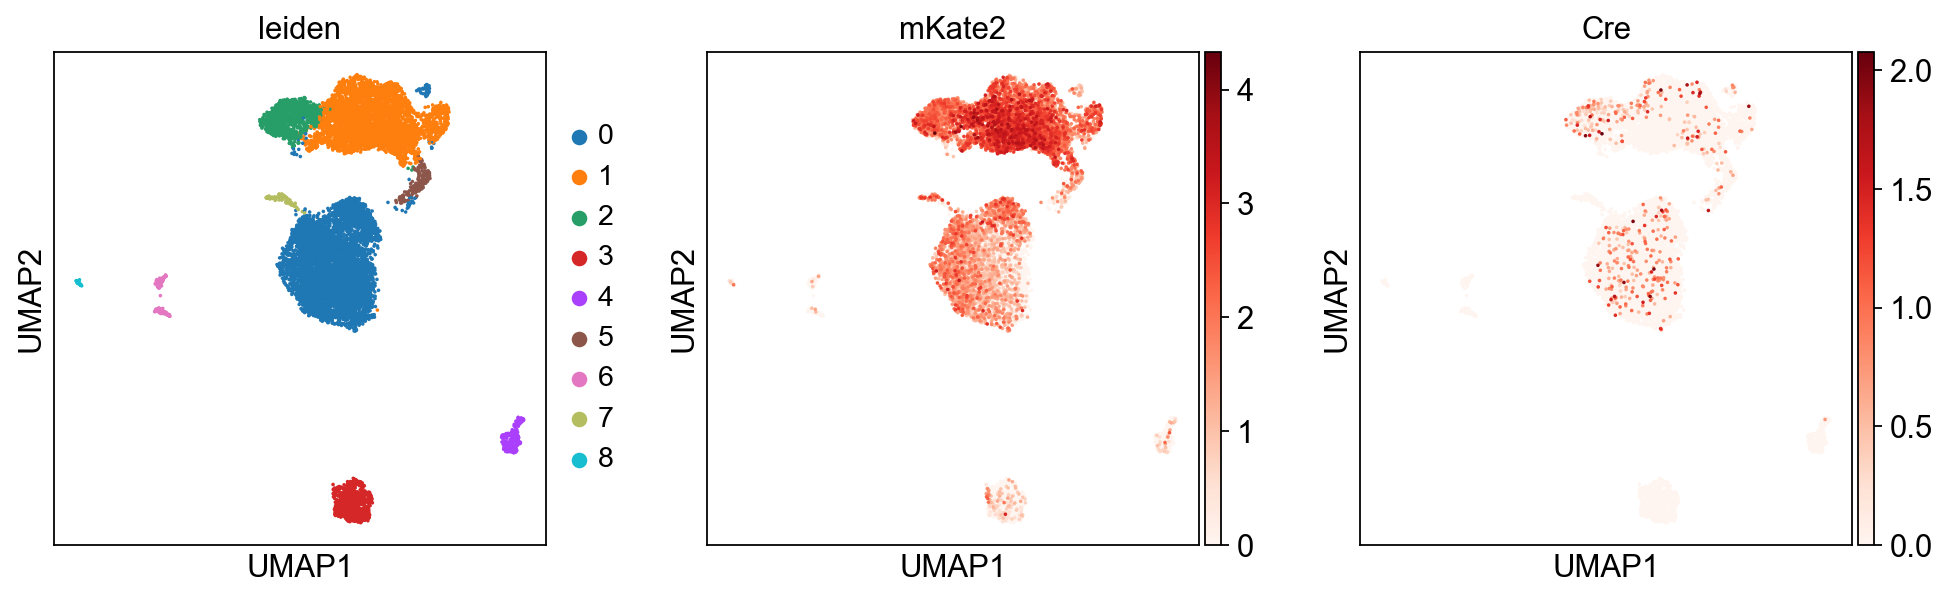

In [73]:
sc.pl.umap(adata,color=['leiden','mKate2','Cre'], cmap='Reds')

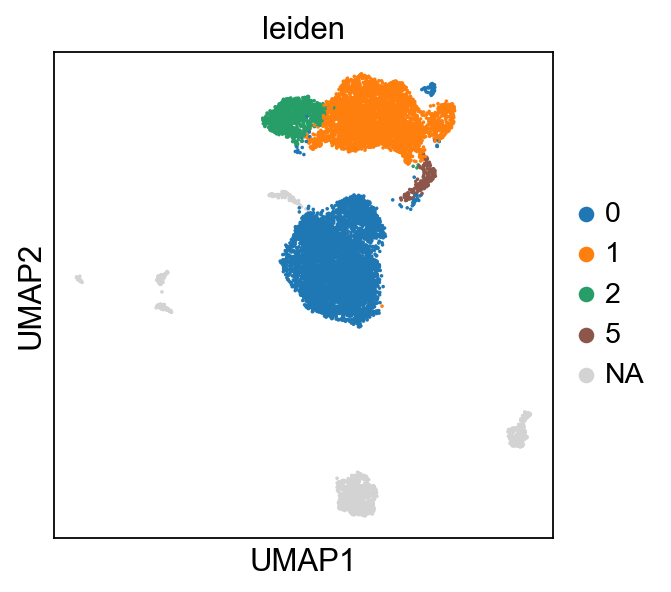

In [74]:
sc.pl.umap(adata, color=['leiden'], groups=['0','1','2','5']) # cluster 3 seems to be fibroblasts

## Select Tumor Cells

In [75]:
# Select only those subset of cells that are useful
adata2 = sc.read('write/JC2499_allmice.h5ad')
adata = adata2[adata.obs['leiden'].isin(['0','1','2','5']),:] # remove fibroblast cells
del adata2

In [76]:
#fix a bug; 'base' is None but that doesn't seem to have transferred
adata.uns['log1p']['base'] = None

In [77]:
sc.pp.highly_variable_genes(adata)#, batch_key='Classification')

extracting highly variable genes
    finished (0:00:00)


/home/chanj2/part2a/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:744: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [78]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['Ikbsr-FLAG'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Cre'] = False
#for x in library:
#    adata.var.highly_variable[x] = False

/tmp/ipykernel_3285603/3736702553.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['Ikbsr-FLAG'] = False
/tmp/ipykernel_3285603/3736702553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

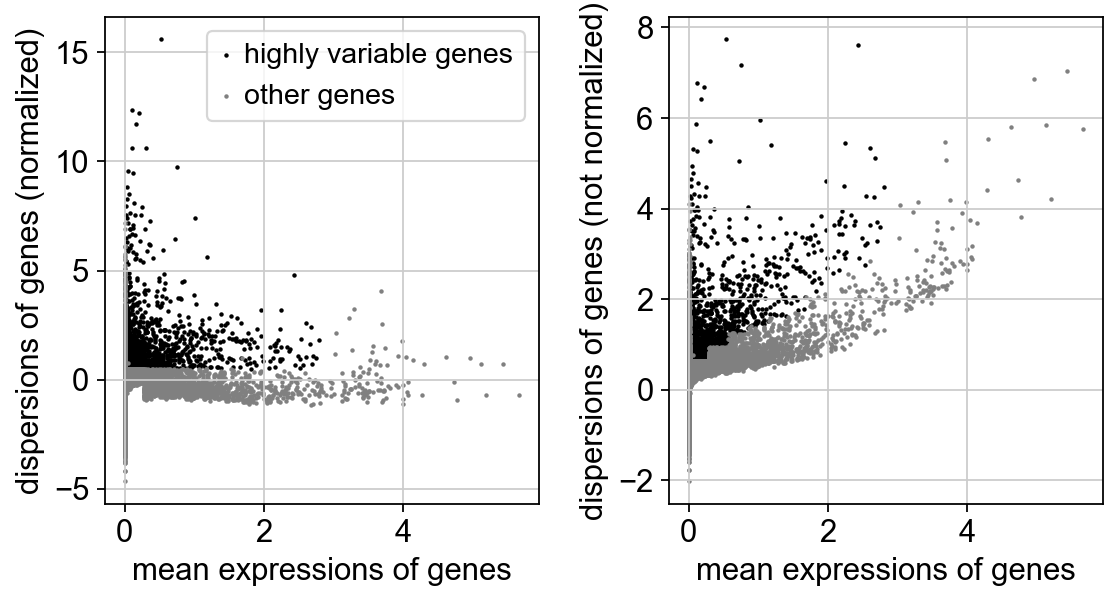

In [79]:
sc.pl.highly_variable_genes(adata)

In [80]:
adata.raw = adata

In [81]:
adata.write('write/JC2499_allmice-tumor.h5ad', compression='gzip')
#adata = sc.read('write/JC2499_allmice-tumor.h5ad')